# Imports

In [94]:
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras as ks
from keras.utils import np_utils
import GPyOpt
from sklearn.model_selection import ParameterSampler

# Data

In [95]:
(train_X, train_y), (test_X, test_y) = mnist.load_data()

print(train_X[1].shape)
#plt.imshow(train_X[1], cmap = "Greys")
#plt.show()

# one-out-of-k encoding of the labels
# using keras' numpy-related utilities
n_classes = 10
print("Shape (train) before one-hot encoding: ", train_y.shape)
Y_train = np_utils.to_categorical(train_y, n_classes)
Y_test = np_utils.to_categorical(test_y, n_classes)
print("Shape (train) after one-hot encoding: ", Y_train.shape)

(28, 28)
Shape (train) before one-hot encoding:  (60000,)
Shape (train) after one-hot encoding:  (60000, 10)


In [96]:
train_X[1].shape

(28, 28)

# CNN Model

In [97]:
CNN = ks.models.Sequential()
# convolutional layer
CNN.add(ks.layers.Conv2D(25, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu', input_shape=(28,28,1)))
CNN.add(ks.layers.MaxPool2D(pool_size=(2,2)))
# flatten output of conv
CNN.add(ks.layers.Flatten())
# hidden layer
CNN.add(ks.layers.Dense(100, activation='relu'))
# output layer
CNN.add(ks.layers.Dense(10, activation='softmax'))

CNN.summary()

CNN.compile(optimizer = "adam", loss = 'categorical_crossentropy', metrics=['accuracy'])

CNN.fit(train_X, Y_train, batch_size = 32)

acc = CNN.evaluate(test_X, Y_test, batch_size = 32)[1]
print(acc)

Model: "sequential_326"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_326 (Conv2D)         (None, 26, 26, 25)        250       
                                                                 
 max_pooling2d_326 (MaxPooli  (None, 13, 13, 25)       0         
 ng2D)                                                           
                                                                 
 flatten_326 (Flatten)       (None, 4225)              0         
                                                                 
 dense_650 (Dense)           (None, 100)               422600    
                                                                 
 dense_651 (Dense)           (None, 10)                1010      
                                                                 
Total params: 423,860
Trainable params: 423,860
Non-trainable params: 0
______________________________________________

# Bayesian Optimization

In [127]:
## define the domain of the considered parameters
n_nodes = tuple(np.arange(1,101,1, dtype= np.int)) # number of nodes of second-last layer (1-100)
batch_size = tuple(np.arange(1,101,1, dtype= np.int)) # batch_size (1-100)

# define the dictionary for GPyOpt
domain = [
    {"name": "n_nodes", "type": "discrete", "domain": n_nodes},
    {"name": "batch_size", "type": "discrete", "domain": batch_size},
]

## we have to define the function we want to maximize --> validation accuracy, 
## note it should take a 2D ndarray but it is ok that it assumes only one point
## in this setting
def objective_function(parameters): 
    #print(x)
    # we have to handle the categorical variables that is convert 0/1 to labels
    # log2/sqrt and gini/entropy
    param = parameters[0]
    #fit the model
    CNN = ks.models.Sequential()
    # convolutional layer
    CNN.add(ks.layers.Conv2D(25, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu', input_shape=(28,28,1)))
    CNN.add(ks.layers.MaxPool2D(pool_size=(2,2)))
    # flatten output of conv
    CNN.add(ks.layers.Flatten())
    # hidden layer
    CNN.add(ks.layers.Dense(int(param[0]), activation='relu'))
    # output layer
    CNN.add(ks.layers.Dense(10, activation='softmax'))

    CNN.compile(optimizer = "adam", loss = 'categorical_crossentropy', metrics=['accuracy'])

    CNN.fit(train_X, Y_train, batch_size = int(param[1]))
    acc = CNN.evaluate(test_X, Y_test, batch_size = int(param[1]))[1]
    print(acc)  
    return - acc # because GPyOpt minimizes everything


opt = GPyOpt.methods.BayesianOptimization(f = objective_function,   # function to optimize
                                              domain = domain,         # box-constrains of the problem
                                              acquisition_type = "EI",      # Select acquisition function MPI, EI, LCB
                                             )
opt.acquisition.exploration_weight=0.5

opt.run_optimization(max_iter = 15, eps = 0) 

x_best = opt.X[np.argmin(opt.Y)]
print("The best parameters obtained: n_nodes=" + str(x_best[0]) + ", batch_size=" + str(x_best[1]))
print(opt.Y.shape)

223/223 [==============================] - 1s 2ms/step - loss: 0.1171 - accuracy: 0.9677
0.9677000045776367
162/162 [==============================] - 1s 3ms/step - loss: 1.1479 - accuracy: 0.5662
0.5662000179290771
715/715 [==============================] - 1s 1ms/step - loss: 0.1040 - accuracy: 0.9687
0.9686999917030334
152/152 [==============================] - 0s 2ms/step - loss: 0.1665 - accuracy: 0.9571
0.957099974155426
114/114 [==============================] - 0s 2ms/step - loss: 2.0283 - accuracy: 0.2078
0.2078000009059906
770/770 [==============================] - 1s 1ms/step - loss: 0.1224 - accuracy: 0.9639
0.9639000296592712
10000/10000 [==============================] - 7s 652us/step - loss: 0.3130 - accuracy: 0.9327
0.932699978351593
100/100 [==============================] - 0s 4ms/step - loss: 0.1593 - accuracy: 0.9587
0.9587000012397766
10000/10000 [==============================] - 6s 556us/step - loss: 2.3019 - accuracy: 0.1135
0.11349999904632568
250/250 [========

# Random Search

In [128]:
import time 

# hyperparams dictionary 

domain = {"n_nodes": n_nodes,
        "batch_size": batch_size}

# create the ParameterSampler
param_list = list(ParameterSampler(domain, n_iter=20, random_state=32))
print('Param list')
print(param_list)
#rounded_list = [dict((k,v) for (k, v) in d.items()) for d in param_list]

#print('Random parameters we are going to consider')
#print(rounded_list)

## now we can train the random forest using these parameters tuple, and for
## each iteration we store the best value of the oob

current_best_acc = 0
iteration_best_acc = 0 
max_acc_per_iteration = []
i = 0
for params in param_list:
    print(i)
    print(params)
    
    #fit the model
    CNN = ks.models.Sequential()
    # convolutional layer
    CNN.add(ks.layers.Conv2D(25, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu', input_shape=(28,28,1)))
    CNN.add(ks.layers.MaxPool2D(pool_size=(2,2)))
    # flatten output of conv
    CNN.add(ks.layers.Flatten())
    # hidden layer
    CNN.add(ks.layers.Dense(params["n_nodes"], activation='relu'))
    # output layer
    CNN.add(ks.layers.Dense(10, activation='softmax'))

    CNN.compile(optimizer = "adam", loss = 'categorical_crossentropy', metrics=['accuracy'])

    start = time.time()
    CNN.fit(train_X, Y_train, batch_size = params["batch_size"])
    end = time.time()
    acc = CNN.evaluate(test_X, Y_test, batch_size = params["batch_size"])[1]
    print('Accuracy found:', acc)
    if acc > current_best_acc:
        current_best_acc = acc
        iteration_best_acc = i
    
    max_acc_per_iteration.append(current_best_acc)
    i += 1
    print(f'It took {end - start} seconds')
    

Param list
[{'n_nodes': 72, 'batch_size': 98}, {'n_nodes': 27, 'batch_size': 96}, {'n_nodes': 31, 'batch_size': 41}, {'n_nodes': 72, 'batch_size': 76}, {'n_nodes': 45, 'batch_size': 85}, {'n_nodes': 44, 'batch_size': 32}, {'n_nodes': 7, 'batch_size': 47}, {'n_nodes': 46, 'batch_size': 68}, {'n_nodes': 44, 'batch_size': 39}, {'n_nodes': 51, 'batch_size': 95}, {'n_nodes': 2, 'batch_size': 83}, {'n_nodes': 25, 'batch_size': 52}, {'n_nodes': 20, 'batch_size': 79}, {'n_nodes': 76, 'batch_size': 95}, {'n_nodes': 43, 'batch_size': 15}, {'n_nodes': 28, 'batch_size': 83}, {'n_nodes': 71, 'batch_size': 98}, {'n_nodes': 43, 'batch_size': 89}, {'n_nodes': 5, 'batch_size': 21}, {'n_nodes': 7, 'batch_size': 36}]
0
{'n_nodes': 72, 'batch_size': 98}
103/103 [==============================] - 0s 3ms/step - loss: 0.1709 - accuracy: 0.9604
Accuracy found: 0.9603999853134155
It took 5.17896580696106 seconds
1
{'n_nodes': 27, 'batch_size': 96}
105/105 [==============================] - 0s 3ms/step - loss: 

# Comparison

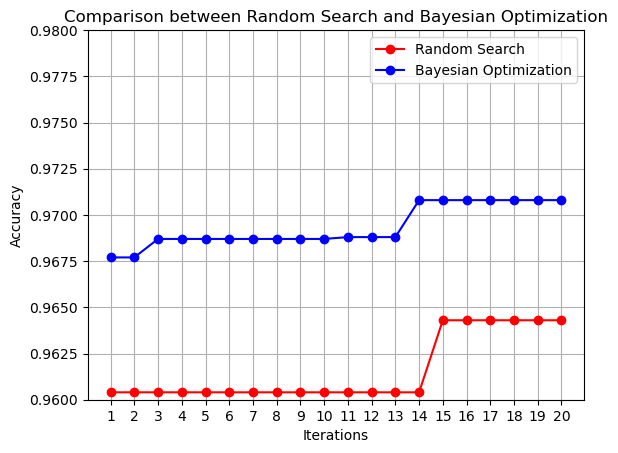

In [129]:
## comparison between random search and bayesian optimization
## we can plot the maximum oob per iteration of the sequence

# collect the maximum each iteration of BO, note that it is also provided by GPOpt in Y_Best
y_bo = np.maximum.accumulate(-opt.Y).ravel()
# define iteration number
xs = np.arange(1,21,1)
xp = np.arange(1,y_bo.shape[0] + 1,1)

plt.plot(xs, max_acc_per_iteration, 'o-', color = 'red', label='Random Search')
plt.plot(xp, y_bo, 'o-', color = 'blue', label='Bayesian Optimization')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Comparison between Random Search and Bayesian Optimization')
plt.ylim(0.96,0.98)
plt.xticks(xs)
plt.grid()
plt.savefig("Single_run_comparison")
plt.show()

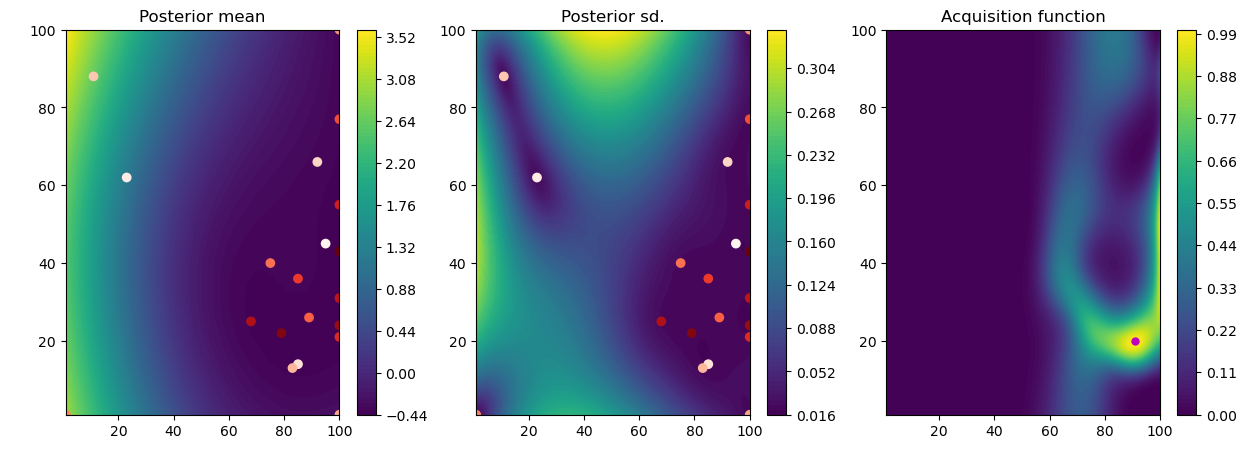

In [137]:
opt.plot_acquisition(label_x = " ", label_y = " ", filename = "Acquisition") #Virker først med 2D



'We can visualise how the algorithm explored the space by looking at the distance between consecutive evaluations. Most of the time there is a sizeable distance between evaluations but on occasion we see consecutive evaluations that are very close to each other - theses evaluations typically correspond to a reduction in the value of the best selected sample.'

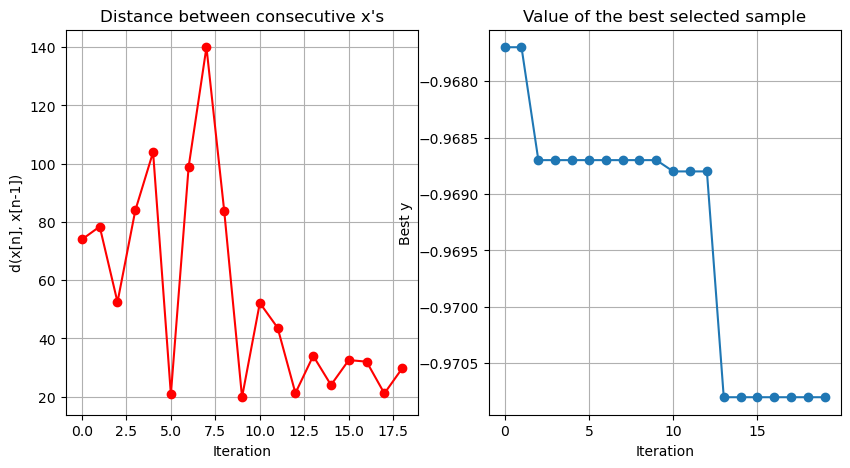

In [139]:
opt.plot_convergence(filename = "Convergence") #Convergence
"""We can visualise how the algorithm explored the space by looking at the distance between consecutive evaluations. Most of the time there is a sizeable distance between evaluations but on occasion we see consecutive evaluations that are very close to each other - theses evaluations typically correspond to a reduction in the value of the best selected sample."""

In [103]:
def objective_function(parameters): 
    #print(x)
    # we have to handle the categorical variables that is convert 0/1 to labels
    # log2/sqrt and gini/entropy
    param = parameters[0]
    #fit the model
    CNN = ks.models.Sequential()
    # convolutional layer
    CNN.add(ks.layers.Conv2D(25, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu', input_shape=(28,28,1)))
    CNN.add(ks.layers.MaxPool2D(pool_size=(2,2)))
    # flatten output of conv
    CNN.add(ks.layers.Flatten())
    # hidden layer
    CNN.add(ks.layers.Dense(int(param[0]), activation='relu'))
    # output layer
    CNN.add(ks.layers.Dense(10, activation='softmax'))

    CNN.compile(optimizer = "adam", loss = 'categorical_crossentropy', metrics=['accuracy'])

    CNN.fit(train_X, Y_train, batch_size = int(param[1]))
    acc = CNN.evaluate(test_X, Y_test, batch_size = int(param[1]))[1]
    print(acc)  
    return - acc # because GPyOpt minimizes everything


In [173]:
n_runs = 5
max_iteration = 10
## define the domain of the considered parameters
n_nodes = tuple(np.arange(1,101,1, dtype= np.int)) # number of nodes of second-last layer (1-100)
batch_size = tuple(np.arange(1,101,1, dtype= np.int)) # batch_size (1-100)


domain_bo = [
    {"name": "n_nodes", "type": "discrete", "domain": n_nodes},
    {"name": "batch_size", "type": "discrete", "domain": batch_size},
]

domain_rs = {"n_nodes": n_nodes,
        "batch_size": batch_size}


acc_bo = []
x_bo = []

acc_rs = []
x_rs = []


for _ in range(n_runs):
    
    # Bayesian Optimization
    opt = GPyOpt.methods.BayesianOptimization(f = objective_function,   # function to optimize
                                              domain = domain_bo,         # box-constrains of the problem
                                              acquisition_type = "EI",      # Select acquisition function MPI, EI, LCB
                                             )
    opt.acquisition.exploration_weight=0.5

    opt.run_optimization(max_iter = max_iteration, eps=0) 

    x_best = opt.X[np.argmin(opt.Y)]
    print("The best parameters obtained: n_nodes=" + str(x_best[0]) + ", batch_size=" + str(x_best[1]))
    y_bo = np.maximum.accumulate(-opt.Y).ravel()
    acc_bo.append(y_bo.tolist())
    x_bo.append(x_best)

    # Random Search
    # create the ParameterSampler
    param_list = list(ParameterSampler(domain_rs, n_iter=y_bo.shape[0], random_state=32))
    print('Param list')
    print(param_list)

    current_best_acc = 0
    iteration_best_acc = 0 
    max_acc_per_iteration = []
    best_param = 0
    i = 0
    for params in param_list:
        print(i)
        print(params)
        
        #fit the model
        CNN = ks.models.Sequential()
        # convolutional layer
        CNN.add(ks.layers.Conv2D(25, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu', input_shape=(28,28,1)))
        CNN.add(ks.layers.MaxPool2D(pool_size=(2,2)))
        # flatten output of conv
        CNN.add(ks.layers.Flatten())
        # hidden layer
        CNN.add(ks.layers.Dense(params["n_nodes"], activation='relu'))
        # output layer
        CNN.add(ks.layers.Dense(10, activation='softmax'))

        CNN.compile(optimizer = "adam", loss = 'categorical_crossentropy', metrics=['accuracy'])

        start = time.time()
        CNN.fit(train_X, Y_train, batch_size = params["batch_size"])
        end = time.time()
        acc = CNN.evaluate(test_X, Y_test, batch_size = params["batch_size"])[1]
        print('Accuracy found:', acc)
        if acc > current_best_acc:
            current_best_acc = acc
            best_param = params
            iteration_best_acc = i
        
        max_acc_per_iteration.append(current_best_acc)

        i += 1
    acc_rs.append(max_acc_per_iteration)
    x_rs.append([best_param["n_nodes"], best_param["batch_size"]])



SyntaxError: closing parenthesis ')' does not match opening parenthesis '[' (534335814.py, line 84)

In [172]:
best_param

{'n_nodes': 72, 'batch_size': 98}

In [167]:
# Best parameters
def most_common(lst):
    return max(set(lst), key=lst.count)

# Bayesian Optimization
x_best_BO = most_common(x_bo)

# Bayesian Optimization
x_best_RS =most_common(x_rs)

print(x_best_BO, x_best_RS)


TypeError: unhashable type: 'numpy.ndarray'

In [157]:
import seaborn as sns
import pandas as pd

data_dict = {"Iteration": [], "Accuracy": [], "Type": []}

for i in range(n_runs):
    for j in range(max_iteration + 5):
        #if acc_bo[i][j] > 0.9:
            data_dict["Accuracy"].append(acc_bo[i][j])
            data_dict["Type"].append("Bayesian Optimization")
            data_dict["Accuracy"].append(acc_rs[i][j])
            data_dict["Type"].append("Random Search")
            data_dict["Iteration"].append(j+1)
            data_dict["Iteration"].append(j+1)

data = pd.DataFrame(data_dict)
print(data)

     Iteration  Accuracy                   Type
0            1    0.9575  Bayesian Optimization
1            1    0.9550          Random Search
2            2    0.9575  Bayesian Optimization
3            2    0.9550          Random Search
4            3    0.9581  Bayesian Optimization
..         ...       ...                    ...
145         13    0.9688          Random Search
146         14    0.9642  Bayesian Optimization
147         14    0.9688          Random Search
148         15    0.9645  Bayesian Optimization
149         15    0.9688          Random Search

[150 rows x 3 columns]


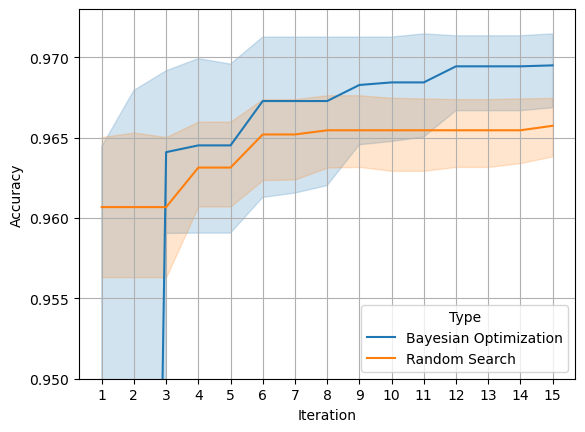

In [165]:
ax = sns.lineplot(data=data, x="Iteration", y="Accuracy", hue = "Type")
plt.xticks(range(1,16))
plt.ylim(0.95,0.973)
plt.ylabel("Accuracy")
plt.grid()
sns.move_legend(ax, "lower right")
plt.savefig("Accuracy_Confidence_interval")